In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)
colors = ["#5657A4", "#95D3A2", "#FFFFBF", "#F79051", "#A30644"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

from main import *
from multiprocessing import Pool
import pandas as pd

SAVE_PATH = r"E:\MS_ExperimentData\general"
# SAVE_PATH = r"D:\MS_ExperimentData\general"
MP4_PATH = r"E:\MS_ExperimentData\mp4"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

In [4]:
k23 = 0.4
model = ChemotacticLotkaVolterra(
    k1=0.01, k2=k23, k3=k23, k4=0.01,
    boundaryLength=20, speedV=0.00, 
    diameter=0.3, repelPower=1,
    omega1=0, omega2=0, filedDrive=False,
    cellNumInLine=200, agentsNum=1000,
    chemoAlpha1=-1, chemoAlpha2=-1,
    diffusionRateD1=0.01, diffusionRateD2=0.01,
    dt=0.01, shotsnaps=200,
    tqdm=True, savePath=SAVE_PATH, overWrite=True
)

In [28]:
np.arange(0.01, 0.32, 0.06)

array([0.01, 0.07, 0.13, 0.19, 0.25, 0.31])

In [5]:
sa = StateAnalysis(model)

(0.0, 20.0)

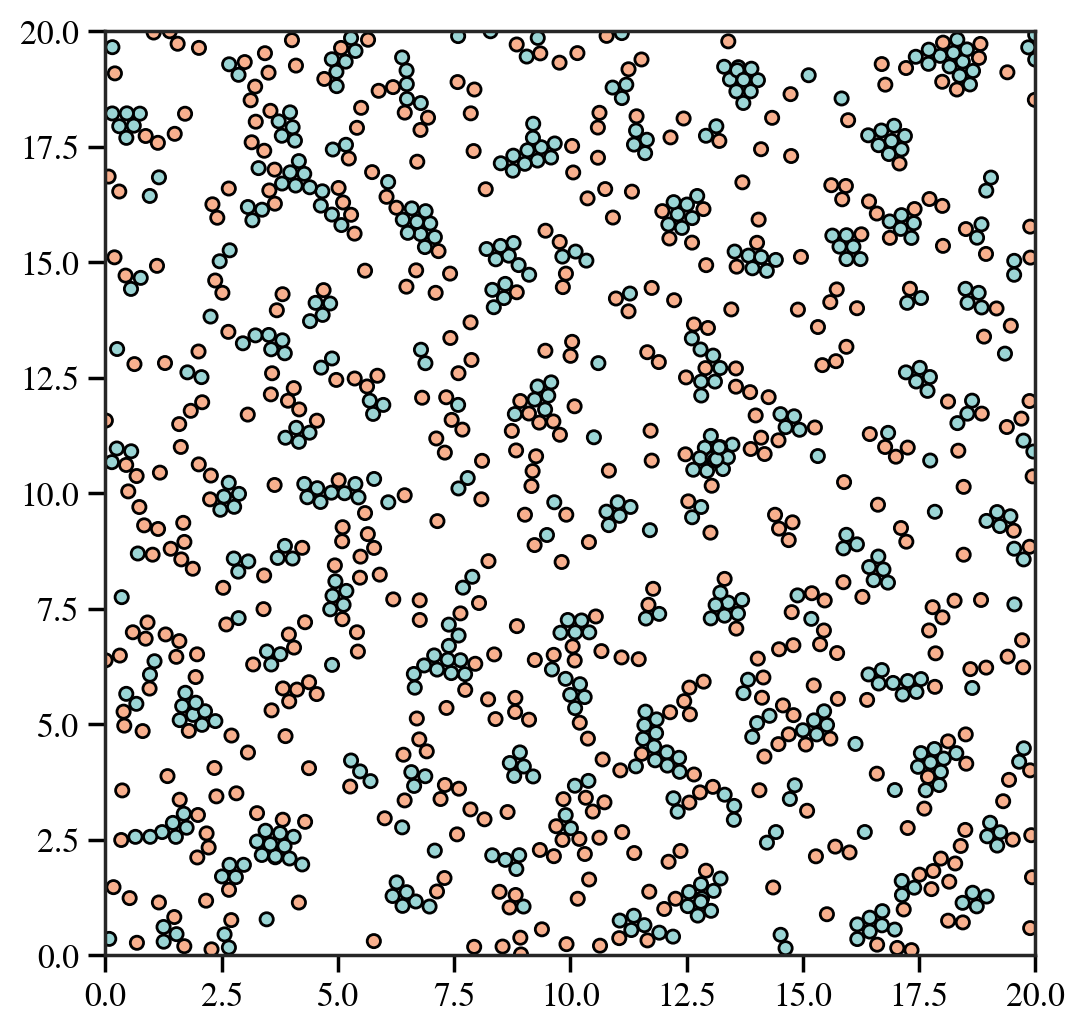

In [23]:
self = sa
ax: plt.Axes = None
oscis: np.ndarray = None
index: int = -1

positionX, _, dotPos = self.get_state(index)

if ax is None:
    fig, ax = plt.subplots(figsize=(6, 6))
if oscis is None:
    oscis = np.arange(self.model.agentsNum)
colors = ["#F8B08E"] * self.model.halfAgentsNum + ["#9BD5D5"] * self.model.halfAgentsNum
for i in oscis:
    ax.add_artist(plt.Circle(
        positionX[i], self.model.diameter / 2 * 0.95, zorder=1, 
        facecolor=colors[i], edgecolor="black"
        # color=colors[i]
    ))
unitDir = dotPos / np.linalg.norm(dotPos, axis=1)[:, None]
colors = ["#F16623"] * self.model.halfAgentsNum + ["#49B2B2"] * self.model.halfAgentsNum
# ax.quiver(
#     positionX[oscis, 0], positionX[oscis, 1],
#     unitDir[oscis, 0], unitDir[oscis, 1], 
#     # color=colors, 
#     facecolor=colors, edgecolor="black",
#     width=0.004, scale=50,
#     **kwargs
# )
ax.set_xlim(0, self.model.boundaryLength)
ax.set_ylim(0, self.model.boundaryLength)

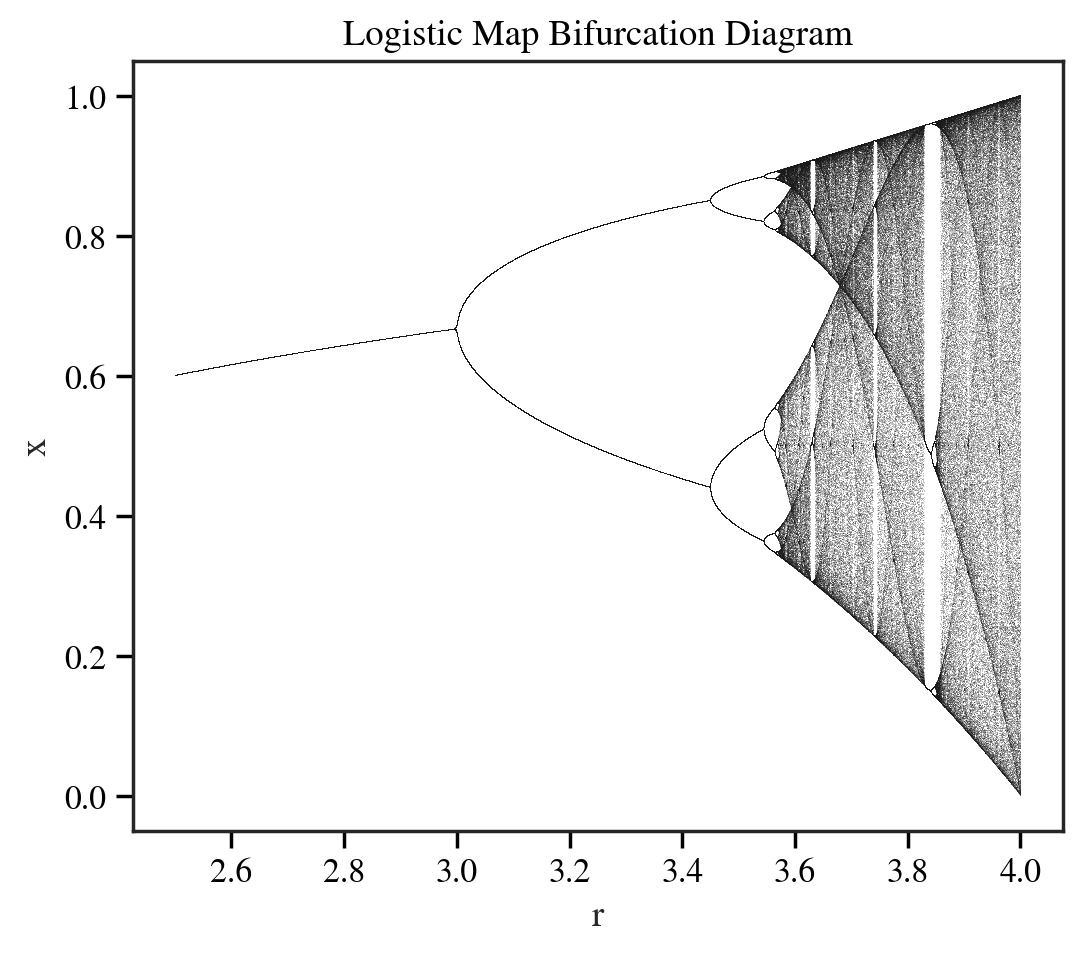

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# 定义Logistic Map函数
def logistic_map(x, r):
    return r * x * (1 - x)

# 生成分岔图数据
def generate_bifurcation_data(r_values, iterations, last):
    x = 1e-5 * np.ones_like(r_values)  # 初始条件
    for _ in range(iterations):
        x = logistic_map(x, r_values)
        if _ >= (iterations - last):  # 只保留最后last次迭代的结果
            plt.plot(r_values, x, ',k', alpha=0.25)
    plt.xlabel('r')
    plt.ylabel('x')
    plt.title('Logistic Map Bifurcation Diagram')
    plt.show()

# 参数设置
r_values = np.linspace(2.5, 4.0, 10000)  # r的范围
iterations = 1000  # 总迭代次数
last = 100  # 只绘制最后100次迭代的结果

# 生成并绘制分岔图
generate_bifurcation_data(r_values, iterations, last)

In [2]:
a = 1
b = -10
diffusionRateDv = 0.002
diffusionRateDu = 0.010

model = ChemotacticLotkaVolterra(
    k1=0.19, k2=0.5, k3=0.5, k4=0.28,
    boundaryLength=10, speedV=0.1, 
    diameter=0.1, repelPower=1,
    cellNumInLine=100, agentsNum=200,
    chemoAlpha1=-10, chemoAlpha2=-10,
    diffusionRateD1=0.01, diffusionRateD2=0.01,
    dt=0.1, shotsnaps=5,
    tqdm=True, savePath=SAVE_PATH, overWrite=True
)

targetPath = f"{model.savePath}/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalDotTheta = pd.read_hdf(targetPath, key="dotTheta")
totalC1 = pd.read_hdf(targetPath, key="c1")
totalC2 = pd.read_hdf(targetPath, key="c2")

TNum = totalPositionX.shape[0] // model.agentsNum
cellNumInLine = model.cellNumInLine

totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalDotTheta = totalDotTheta.values.reshape(TNum, model.agentsNum)
totalC1 = totalC1.values.reshape(TNum, cellNumInLine, cellNumInLine)
totalC2 = totalC2.values.reshape(TNum, cellNumInLine, cellNumInLine)
maxC1 = totalC1.max()
maxC2 = totalC2.max()

In [3]:
sa = StateAnalysis(model)

In [4]:
def draw_frame(sa: StateAnalysis, idx: int):
    fig = plt.figure(figsize=(13.5, 4))
    ax1 = fig.add_subplot(131)
    sa.plot_spatial(ax=ax1, index=idx, color=["#FF4B4E"] * sa.model.halfAgentsNum + ["#414CC7"] * sa.model.halfAgentsNum)
    ax2 = fig.add_subplot(132)
    im = ax2.pcolor(sa.totalC1[idx].T, cmap=cmap, vmin=0, vmax=maxC1)
    plt.colorbar(im, ax=ax2, cmap=cmap)
    ax3 = fig.add_subplot(133)
    im = ax3.pcolor(sa.totalC2[idx].T, cmap=cmap, vmin=0, vmax=maxC2)
    plt.colorbar(im, ax=ax3, cmap=cmap)
    ax1.set_aspect("equal")
    plt.tight_layout()

  0%|          | 0/202 [00:00<?, ?it/s]

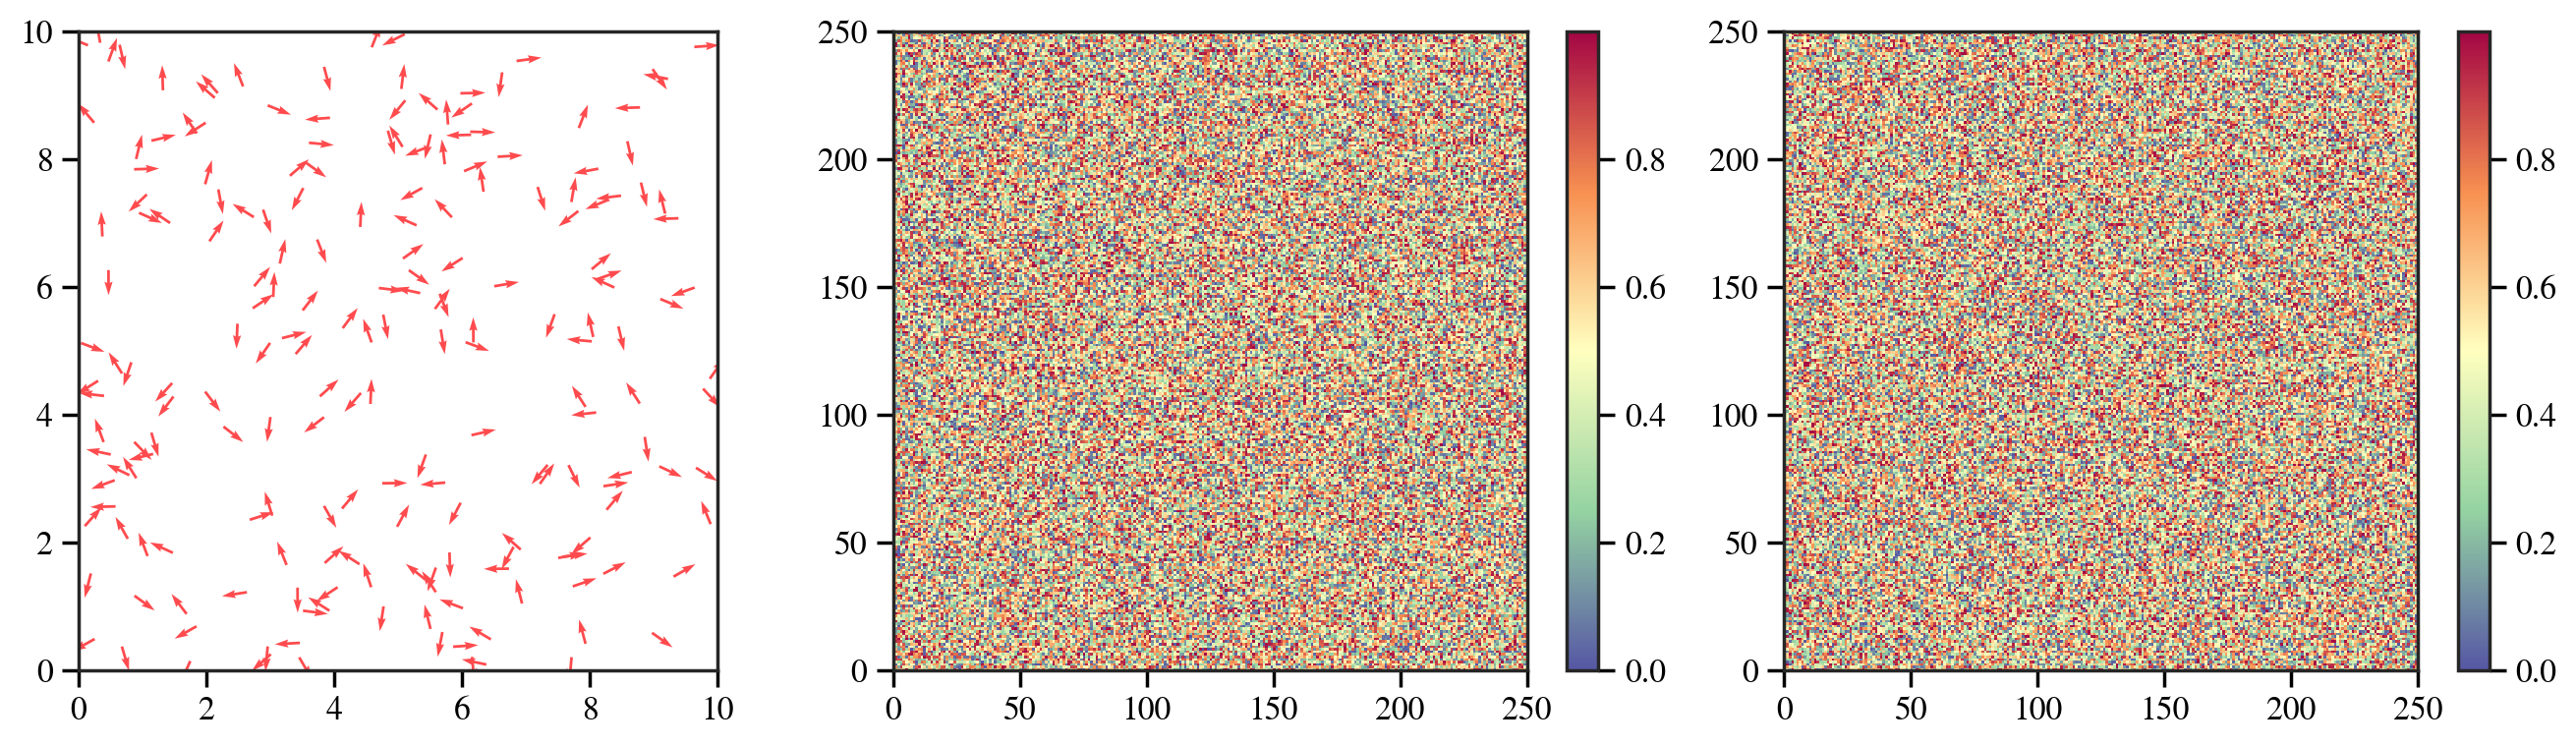

In [3]:
from matplotlib.animation import FuncAnimation

sa = StateAnalysis(model)
fig, axs = plt.subplots(1, 3, figsize=(13.5, 4))

def animate(i):
    fig.clear()
    ax1 = fig.add_subplot(131)
    sa.plot_spatial(ax=ax1, index=i, color=["#FF4B4E"] * 500 + ["#414CC7"] * 500)
    ax2 = fig.add_subplot(132)
    im = ax2.pcolor(totalC1[i].T, cmap=cmap, vmin=0, vmax=maxC1)
    plt.colorbar(im, ax=ax2, cmap=cmap)
    ax3 = fig.add_subplot(133)
    im = ax3.pcolor(totalC2[i].T, cmap=cmap, vmin=0, vmax=maxC2)
    plt.colorbar(im, ax=ax3, cmap=cmap)
    ax1.set_aspect("equal")
    plt.tight_layout()
    pbar.update()
    return im

pbar = tqdm(total=len(totalC1))
ani = FuncAnimation(fig, animate, frames=len(totalC1), interval=50, repeat=False)
ani.save(f"{MP4_PATH}/sample2.mp4", writer="ffmpeg", fps=10, dpi=150)

In [ ]:
a = 1
b = -10
diffusionRateDv = 0.002
diffusionRateDu = 0.010

model = GSPatternFormation(strengthLambda=0, alpha=a, 
        boundaryLength=10, cellNumInLine=250, 
        productRateUK0=1, productRateVK0=1,
        decayRateKd=0.001, 
        chemoBetaU=b, chemoBetaV=b,
        diffusionRateDu=diffusionRateDu, diffusionRateDv=diffusionRateDv,
        dt=0.02, shotsnaps=5,
        tqdm=True, savePath=SAVE_PATH, overWrite=True)

targetPath = f"{model.savePath}/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalDotTheta = pd.read_hdf(targetPath, key="dotTheta")
totalU = pd.read_hdf(targetPath, key="u")
totalV = pd.read_hdf(targetPath, key="v")

TNum = totalPositionX.shape[0] // model.agentsNum
cellNumInLine = model.cellNumInLine

totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalDotTheta = totalDotTheta.values.reshape(TNum, model.agentsNum)
totalU = totalU.values.reshape(TNum, cellNumInLine, cellNumInLine)
totalV = totalV.values.reshape(TNum, cellNumInLine, cellNumInLine)

In [10]:
import os
import subprocess

image_folder = r"E:\MS_ExperimentData\mp4_temp"  # 图片文件夹路径
output_video = r"E:\MS_ExperimentData\out.mp4"      # 输出视频文件名
fps = 30                                 # 帧率

# 生成 FFmpeg 命令
# 假设图片格式为 jpg，且命名规则为 img001.jpg, img002.jpg, ...
ffmpeg_command = [
    'ffmpeg',
    '-framerate', str(fps),
    '-i', os.path.join(image_folder, "%d.png"),  # 根据命名规则调整
    '-c:v', 'libx264',
    '-pix_fmt', 'yuv420p',
    output_video
]

# 调用 FFmpeg
subprocess.run(ffmpeg_command)

CompletedProcess(args=['ffmpeg', '-framerate', '30', '-i', 'E:\\MS_ExperimentData\\mp4_temp\\%d.png', '-c:v', 'libx264', '-pix_fmt', 'yuv420p', 'E:\\MS_ExperimentData\\out.mp4'], returncode=0)

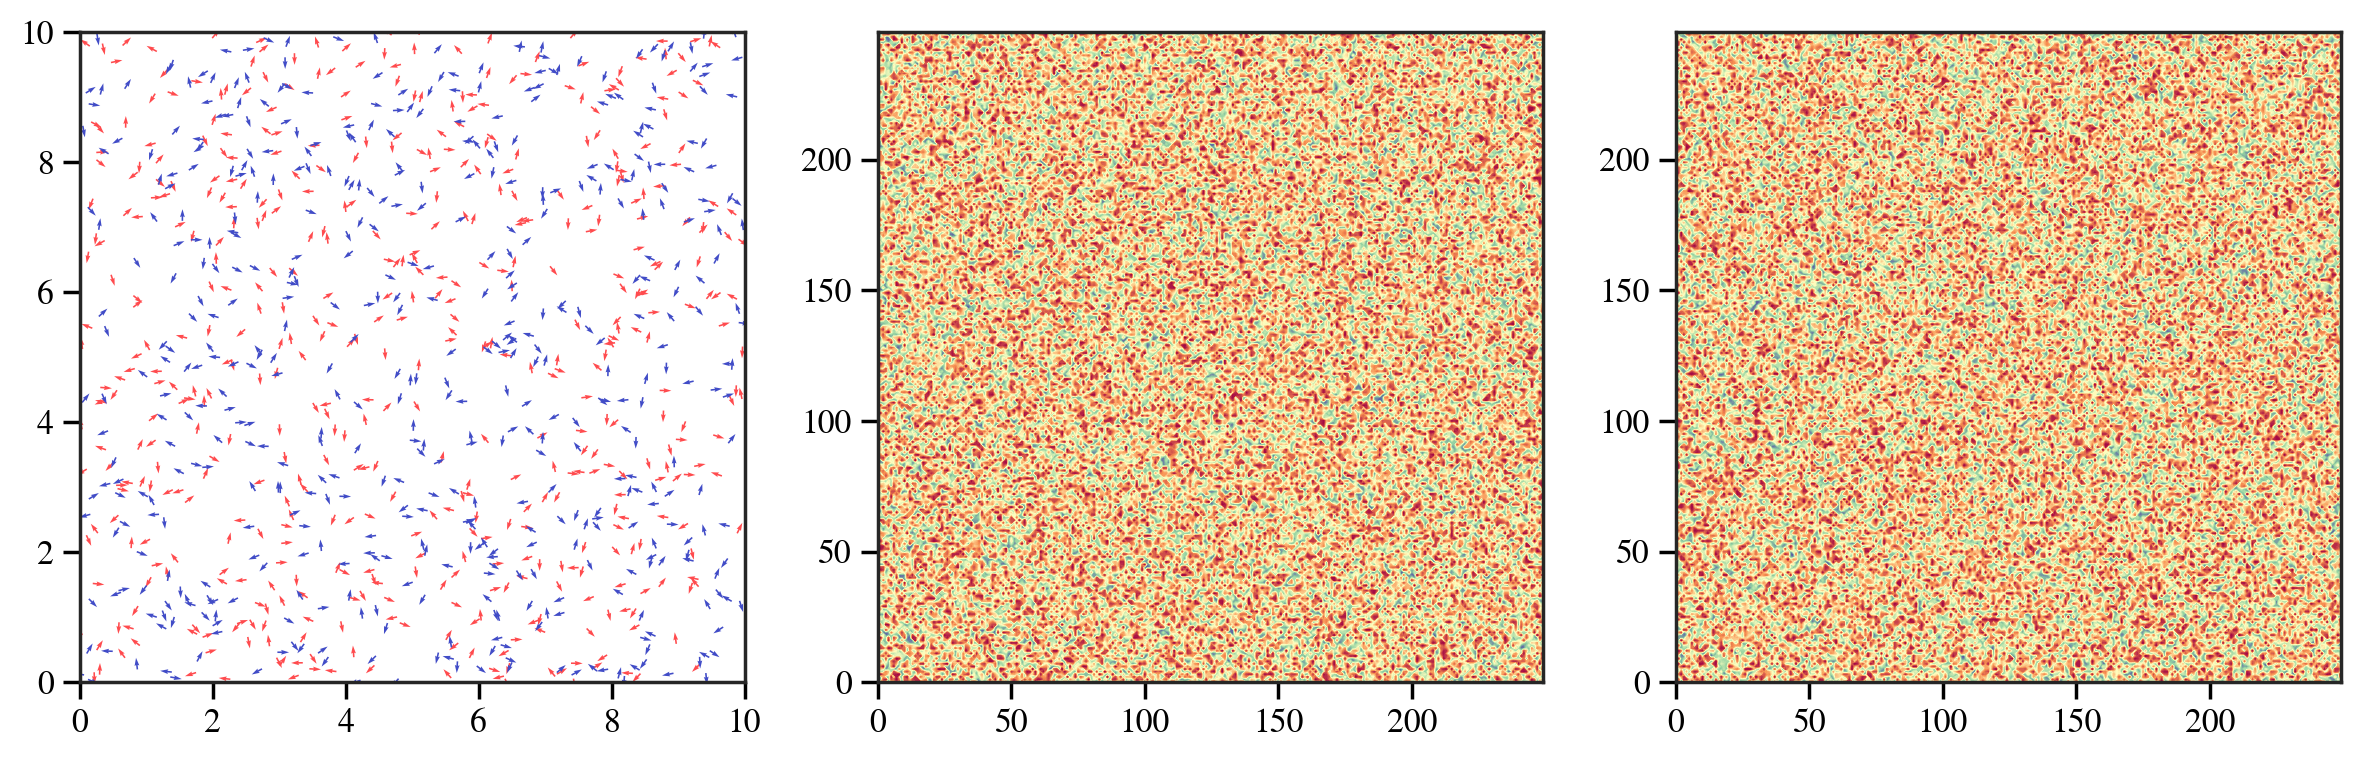

In [4]:
from matplotlib.animation import FuncAnimation

sa = StateAnalysis(model)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

def animate(i):
    fig.clear()
    ax1 = fig.add_subplot(131)
    sa.plot_spatial(ax=ax1, index=i, color=["#FF4B4E"] * 500 + ["#414CC7"] * 500)
    ax2 = fig.add_subplot(132)
    im = ax2.contourf(totalU[i].T, cmap=cmap, levels=50)
    ax3 = fig.add_subplot(133)
    im = ax3.contourf(totalV[i].T, cmap=cmap, levels=50)
    plt.tight_layout()
    return im

ani = FuncAnimation(fig, animate, frames=len(totalU), interval=50, repeat=False)
ani.save('sample0.mp4', writer='ffmpeg', fps=10, dpi=150)

In [ ]:
# sample1
model = GSPatternFormation(0.65, 0.45, boundaryLength=10, cellNumInLine=80, 
                           diffusionRateDc=0.01, 
                           epsilon=10, c0=0.012, chemotacticStrengthBetaR=5,
                           dt=0.02, shotsnaps=5,
                           tqdm=True, savePath="data", overWrite=True)
# sample2
model = GSPatternFormation(0.65, 0.45, boundaryLength=10, cellNumInLine=80, 
                           diffusionRateDc=0.01, 
                           epsilon=10, c0=0.012, chemotacticStrengthBetaR=1,
                           dt=0.02, shotsnaps=5,
                           tqdm=True, savePath="data", overWrite=True)
# sample3
model = GSPatternFormation(0.1, 1.5, boundaryLength=10, cellNumInLine=80, 
                           diffusionRateDc=0.01, productRateK0=2,
                           epsilon=10, c0=0.012, chemotacticStrengthBetaR=1,
                           dt=0.02, shotsnaps=5,
                           tqdm=True, savePath="data", overWrite=True)
# sample4
model = GSPatternFormation(0.1, 1.5, boundaryLength=10, cellNumInLine=80, 
                           diffusionRateDc=0.01, productRateK0=2,
                           epsilon=10, c0=0.012, chemotacticStrengthBetaR=10,
                           dt=0.02, shotsnaps=5,
                           tqdm=True, savePath="data", overWrite=True)